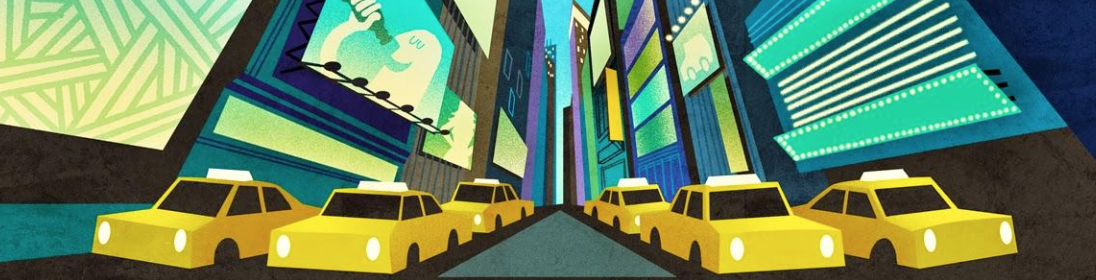

In [911]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-trips-2023/Taxi_Trips_-_2023.csv
/kaggle/input/taxi-trips-2022-v-2/Taxi_Trips_-_2022.csv


In [912]:
!pip3 install pyspark

In [913]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.window import Window
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StringType, ShortType, IntegerType, TimestampType, LongType, StructType, StructField, DoubleType
from pyspark.ml.evaluation import RegressionEvaluator

from pandas.tseries.holiday import USFederalHolidayCalendar

from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from xgboost.spark import SparkXGBRegressor
from prophet import Prophet

from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [914]:
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.plotting.backend = "plotly"

## Описание данных

- Trip ID - A unique identifier for the trip.
- Taxi ID - A unique identifier for the taxi.
- Trip Start Timestamp - When the trip started, rounded to the nearest 15 minutes.
- Trip End Timestamp - When the trip ended, rounded to the nearest 15 minutes.
- Trip Seconds - Time of the trip in seconds.
- Trip Miles - Distance of the trip in miles.
- Pickup Census Tract - The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.
- Dropoff Census Tract - The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.
- Pickup Community Area - The Community Area where the trip began. This column will be blank for locations outside Chicago.
- Dropoff Community Area -The Community Area where the trip ended. This column will be blank for locations outside Chicago.
- Fare - The fare for the trip.
- Tips -The tip for the trip. Cash tips generally will not be recorded.
- Tolls -The tolls for the trip.
- Extras - Extra charges for the trip.
- Trip Total - Total cost of the trip, the total of the previous columns.
- Payment Type - Type of payment for the trip.
- Company -The taxi company.

# 1. Загружаем и преобразуем данные

**Источник данных**

[][https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz]

In [915]:
spark = SparkSession.builder.appName('taxi').getOrCreate()
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
spark.sparkContext.setLogLevel("ERROR")

Py4JError: SparkSession$ does not exist in the JVM

In [ ]:
print('Spark Version: {}'.format(spark.version))

In [ ]:
file_path_1 = '/kaggle/input/taxi-trips-2022-v-2/Taxi_Trips_-_2022.csv'

df = spark.read.csv(file_path_1,
                    header = True,
                    inferSchema = True,
                    nanValue = '').cache()

**Размер датафрейма**

In [ ]:
(df.count(), len(df.columns))

## 1.1. Schema

In [ ]:
df.printSchema()

## 1.2. Изменяем наименование колонок

In [ ]:
df = df.toDF(*['_'.join(i.lower().split()) for i in df.columns])

In [ ]:
df.columns

## 1.2. Проверяем на пропуски

In [ ]:
#df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

## 1.3. Изменяем тип данных

In [ ]:
df = df.withColumn('trip_start_timestamp', F.to_timestamp(F.col('trip_start_timestamp'), 'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn('trip_end_timestamp', F.to_timestamp(F.col('trip_end_timestamp'), 'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn("pickup_community_area", F.col("pickup_community_area").cast("int"))
df = df.withColumn("dropoff_community_area",F. col("dropoff_community_area").cast("int"))

## 1.4. Создаем дополнительные фитчи

In [ ]:
df.limit(5).toPandas()

**Минимальная дата и максимальная дата**

In [ ]:
t = df.agg(F.min('trip_start_timestamp').alias('min_date'), F.max('trip_start_timestamp').alias('max_date'))
t.show()

In [ ]:
min_start_date = t.head()[0]
max_start_date = t.head()[1]

In [ ]:
min_start_date, max_start_date

## 1.4. Drop unnesassery columns

In [916]:
columns_to_drop = [ 'trip_id', 'taxi_id', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
                   'pickup_centroid_longitude', 'pickup_centroid_longitude', 'pickup_centroid_longitude',
                   'pickup_centroid_longitude', 'dropoff_centroid_longitude', 'dropoff_centroid_location',
                   'pickup_centroid_location', 'pickup_centroid_location', 'dropoff_centroid_latitude',
                    'pickup_census_tract', 'dropoff_census_tract', 'company', 'payment_type', 'fare', 'tips',
                   'tolls', 'extras','trip_total']
df = df.drop(*columns_to_drop)

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
df.show(10)

## 1.5. Заполняем пропуски

In [ ]:
df = df.na.fill(99,subset=["pickup_community_area"])
df = df.na.fill(98,subset=["dropoff_community_area"])

### 1.6. Посмотрим на количество районов

In [917]:
df.select(F.countDistinct("pickup_community_area")).show()

ConnectionRefusedError: [Errno 111] Connection refused

In [918]:
df.select("pickup_community_area").distinct().show()

ConnectionRefusedError: [Errno 111] Connection refused

## 1.6. Анализ целевой переменной

### 1.6.1 Количество заказов по районам

In [919]:
t = df.groupBy("pickup_community_area").count().toPandas()
t = t.sort_values(by='count',ascending=False)
t['pickup_community_area'] = t['pickup_community_area'].astype('str')


fig = px.bar(t, y='pickup_community_area', x='count',
              title='Количество заказов по районам',
              labels={
                     "pickup_community_area": "Район",
                     "count": "Количество"
                 },
              width=1200,
              height=700,
              orientation='h')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

ConnectionRefusedError: [Errno 111] Connection refused

По количеству заказов разброс очень большой. Есть районы с большим количество есть с маленьким.

### 1.6.1 Количество заказов по дню по всем районам[](http://)

In [920]:
# t = df.groupby(F.date_trunc('day', F.col('trip_start_timestamp')).alias('start_date')) \
#                                                      .agg(F.count('*').alias('cnt_target')) \
#                                                      .orderBy('start_date') \
#                                                      .toPandas()

# t = t.set_index('start_date')


# fig = px.line(t, t.index, y="cnt_target",
#               title='Количество заказов',
#               labels={
#                      "start_date_hour": "Дата час",
#                      "cnt_target": "Количество"
#                  },
#               width=1400,
#               height=600)
# fig.show()

Видим тренд к лету увеличивается количестов заказов, а также сезонность по неделям

### 1.6.3 Количество заказов по районам

In [921]:
# t = df.groupBy(F.date_trunc('day', F.col('trip_start_timestamp')).alias('date'))\
#                                                                  .agg(F.count('*').alias('cnt_target')) \
#                                                                  .orderBy('date') \
#                                                                  .toPandas()

# t = t.set_index('date')

# fig = px.line(t, t.index, y="cnt_target",
#               title='Количество заказов по дню недели',
#               labels={
#                      "hour_trip_start_timestamp": "Дата",
#                      "cnt_target": "Количество"
#                  },
#               width=1400,
#               height=600)
# fig.show()

### 1.4.3 По районам

In [922]:
# t = df.groupBy('pickup_community_area', F.date_trunc('day', F.col('trip_start_timestamp')).alias('date'))\
#                                                                  .agg(F.count('*').alias('count')) \
#                                                                  .orderBy('date') \
#                                                                  .toPandas()

# t = t.set_index('date')

# fig = px.line(t, t.index, y="count",
#               title='Количество заказов по дню недели',
#               labels={
#                      "hour_trip_start_timestamp": "Дата",
#                      "count": "Количество"
#                  },
#               color = 'pickup_community_area',
#               width=1400,
#               height=600)
# fig.show()

Распределение по районам приблизительно одинаковые

Посмотрим на маленькие районы по которым мало данных:

In [923]:
# s = set([11, 53, 5, 2, 3])

# fig = px.line(t[t.pickup_community_area.isin(s)], t[t.pickup_community_area.isin(s)].index, y="count",
#               title='Количество заказов по дню недели',
#               labels={
#                      "hour_trip_start_timestamp": "Дата",
#                      "count": "Количество"
#                  },
#               color = 'pickup_community_area',
#               width=1400,
#               height=600)
# fig.show()

### 1.6.3. Количество заказов по месяцам по районам

In [924]:
# t = df.groupBy('pickup_community_area', F.month(F.col("trip_start_timestamp")).alias('month')) \
#                                                                      .agg(F.count('*').alias('count')) \
#                                                                      .toPandas().set_index('month') \
#                                                                      .sort_values(by=['month', 'count'],ascending=[True, True])

# fig = px.bar(t, y=t.index, x='count',
#               title='Количество заказов по месяцам',
#               labels={
#                      "count": "Количество",
#                      "month": "Месяц"
#                  },
#               width=1200,
#               height=600,
#               color='pickup_community_area',
#               orientation='h')
# fig.update_layout(yaxis=dict(autorange="reversed"))
# fig.show()

## 1.6.1 Недельная сезонность

In [925]:
# t = df.groupBy(F.date_trunc('day', F.col('trip_start_timestamp')).alias('date'))\
#                                                                  .agg(F.count('*').alias('count')) \
#                                                                  .orderBy('date') \
#                                                                  .toPandas()

# t = t.set_index('date')

In [926]:
# t = df.filter(F.month(F.col("trip_start_timestamp")) == 4).groupBy(F.date_trunc('day', F.col('trip_start_timestamp'))
#                                                                  .alias('date'))\
#                                                                  .agg(F.count('*').alias('count')) \
#                                                                  .orderBy('date') \
#                                                                  .toPandas()

# t = t.set_index('date')

In [927]:
# fig = px.line(t, t.index, y="count",
#               title='Количество заказов в апреле',
#               labels={
#                      "date": "Дата",
#                      "count": "Количество"
#                  },
#               width=1400,
#               height=600)
# fig.show()

Видим еженедельную сезонность

In [928]:
# #функция отрисовки
# def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
#     x_values = dates if dates is not None else np.arange(len(result.observed))
#     return (
#         make_subplots(
#             rows=4,
#             cols=1,
#             subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
#         )
#         .add_trace(
#             go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
#             row=1,
#             col=1,
#         )
#         .add_trace(
#             go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
#             row=2,
#             col=1,
#         )
#         .add_trace(
#             go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
#             row=3,
#             col=1,
#         )
#         .add_trace(
#             go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
#             row=4,
#             col=1,
#         )
#         .update_layout(
#             height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
#         )
#     )

In [929]:
# decomposition = seasonal_decompose(t['count'], model='additive')
# fig = plot_seasonal_decompose(decomposition, dates=t.index)
# fig.show()

### 1.6.1 Количество заказов в течение недели

In [930]:
# t = df.filter((F.month(F.col("trip_start_timestamp")) == 3) & (F.date_format(F.col("trip_start_timestamp"), "W")==2)) \
#                                 .groupBy(F.date_trunc('hour', F.col('trip_start_timestamp')).alias('hour')) \
#                                 .agg(F.count('*').alias('count')) \
#                                 .orderBy('hour') \
#                                 .toPandas().set_index('hour')

In [931]:
# fig = px.line(t, t.index, y="count",
#               title='Количество заказов по дню недели',
#               labels={
#                      "hour_trip_start_timestamp": "Дата",
#                      "count": "Количество"
#                  },
#               width=1400,
#               height=600)
# fig.show()

In [932]:
# decomposition = seasonal_decompose(t['count'], model='additive')
# fig = plot_seasonal_decompose(decomposition, dates=t.index)
# fig.show()

Есть дневная сезонность и тренд внутри недели на повышение и тренды внутри дня

### Количество заказов в течение месяца

In [933]:
# df.groupby('trip_start_timestamp', F.window('trip_start_timestamp','1 day')) \
#                                 .agg(F.count('*').alias('count')) \
#                                 .orderBy('window') \
#                                 .show(10)

In [934]:
# t = df.groupby(F.window('trip_start_timestamp','1 day')) \
#                                 .agg(F.count('*').alias('count')) \
#                                 .orderBy('window') \
#                                 .toPandas()

In [935]:
# t.head(10)

In [936]:
# fig = px.line(t, t.index, y="count",
#               title='Количество заказов по дню недели',
#               labels={
#                      "hour_trip_start_timestamp": "Дата",
#                      "count": "Количество"
#                  },
#               width=1400,
#               height=600)
# fig.show()

## 2.5 !!! Выводы по EDA

1. Есть недельная сезонность
2. Есть дневная сезонность
3. !!! Добавить праздники US Holiday
5. 

# 4. Feature Enginiring

In [937]:
AREA = 32

## 4.1. **Создаем Range из даты начала и окончания**

In [938]:
def generate_series(start, stop, interval) -> DataFrame:
    """
    :param start  - lower bound, inclusive
    :param stop   - upper bound, exclusive
    :interval int - increment interval in seconds
    
    """

    start, stop = spark.createDataFrame(
        [(start, stop)], ("start", "stop")
    ).select(
        [F.col(c).cast("timestamp").cast("long") for c in ("start", "stop")
    ]).first()
    return spark.range(start, stop, interval).select(
        F.col("id").cast("timestamp").alias("ds")
    )

In [939]:
min_start_date, max_start_date

(datetime.datetime(2022, 1, 1, 0, 0), datetime.datetime(2022, 12, 31, 23, 45))

In [940]:
generate_series(min_start_date, max_start_date, 60 * 60).show(5)
date_range_t = generate_series(min_start_date, max_start_date, 60 * 60)

ConnectionRefusedError: [Errno 111] Connection refused

In [941]:
date_range_t.printSchema()

ConnectionRefusedError: [Errno 111] Connection refused

In [838]:
#check
date_range_t.toPandas().set_index('ds').index.is_monotonic_increasing

True

In [839]:
date_range_t.toPandas().head(5)

,ds
0,2022-01-01 00:00:00
1,2022-01-01 01:00:00
2,2022-01-01 02:00:00
3,2022-01-01 03:00:00
4,2022-01-01 04:00:00


## Фильтруем и создаем данные

In [840]:
def create_buckets(df_t: DataFrame, date_range_t: DataFrame, area: int) -> DataFrame :
    """
    """
    
    # filtering and creating data
    df_area = df_t.filter(df_t.pickup_community_area == area).groupby(F.date_trunc('hour', F.col('trip_start_timestamp')).alias('start_date_hour')) \
                                                                                                                         .agg(F.count('*').alias('y')) \
                                                                                                                         .orderBy('start_date_hour')
    
    #df_area = df_area.withColumn('id', F.monotonically_increasing_id())
    
    
    #Join 2 DF range and main
    df_area = date_range_t.join(df_area, date_range_t.ds == df_area.start_date_hour, "left")
    
    
    #Add features day_of_week, hour, month, week_of_month
    df_area = df_area.withColumn("day_of_week",F.dayofweek(F.col("ds")))
    df_area = df_area.withColumn("hour",F.hour(F.col("ds")))
    #df_area = df_area.withColumn("month",F.month(F.col("ds")))
    #df_area = df_area.withColumn("week_of_month", F.date_format(F.col("ds"), "W"))
    
    #Add sin_cos
    #df_area['sin_hour'] = np.sin(2*np.pi*df['hour']/24)
    #df_area['cos_hour'] = np.cos(2*np.pi*df['hour']/24)
    
    #Fill NA Values
    df_area = df_area.fillna(0, subset=['y'])
    
    
    #Add Holidas features
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2022-01-01', end='2024-01-01').to_pydatetime()
    holidays = set([str(datetime.datetime.date(i)) for i in holidays])
    holidayUDF = F.udf(lambda x: 1 if str(datetime.datetime.date(x)) in holidays else 0, ShortType())
    
    df_area = df_area.withColumn('holiday', holidayUDF(F.col('ds')))
    
    #Add After Holiday feature
    # w = Window().partitionBy().orderBy('start_date_hour_t')
    # df_area = df_area.withColumn("after_holiday", F.lag(F.col('holiday'), 1).over(w).cast("short"))
    
    #Add Lags
    w = Window().partitionBy().orderBy('ds')

    for i in range(1, 24 + 1):
        df_area = df_area.withColumn(f"lag_{i}", F.lag(F.col('y'), i).over(w).cast("integer"))


    w = Window().partitionBy().orderBy('ds')

    for i in range(24, 24*8, 24):
        df_area = df_area.withColumn(f"lag_{i}", F.lag(F.col('y'), i).over(w).cast("integer"))
    
    #Rolling mean
    #cumulative_window = Window().partitionBy().orderBy('ds').rowsBetween(-24,0)
    #df_area = df_area.withColumn('y_avg', F.avg('y').over(cumulative_window))

    #Drop NA Columns
    df_area = df_area.drop('start_date_hour')
    df_area = df_area.na.drop()

    return df_area

In [841]:
df_a = create_buckets(df, date_range_t, 32).cache()

In [842]:
df_a.limit(5).toPandas()

,ds,y,day_of_week,hour,holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_48,lag_72,lag_96,lag_120,lag_144,lag_168
0,2022-01-08 00:00:00,12,7,0,0,30,35,29,46,83,102,155,117,115,82,71,71,52,60,61,77,54,18,5,1,0,5,2,11,4,7,7,3,10,37
1,2022-01-08 01:00:00,6,7,1,0,12,30,35,29,46,83,102,155,117,115,82,71,71,52,60,61,77,54,18,5,1,0,5,2,2,2,5,7,4,70
2,2022-01-08 02:00:00,11,7,2,0,6,12,30,35,29,46,83,102,155,117,115,82,71,71,52,60,61,77,54,18,5,1,0,5,2,1,5,4,2,67
3,2022-01-08 03:00:00,3,7,3,0,11,6,12,30,35,29,46,83,102,155,117,115,82,71,71,52,60,61,77,54,18,5,1,0,1,3,4,3,4,39
4,2022-01-08 04:00:00,7,7,4,0,3,11,6,12,30,35,29,46,83,102,155,117,115,82,71,71,52,60,61,77,54,18,5,1,2,3,1,6,8,26


### 5.1. Change data type

In [843]:
def change_data_type(df_t: DataFrame) -> DataFrame:
    """
    
    """
    df_t = df_t.withColumn("y",F.col("y").cast("integer"))
    df_t = df_t.withColumn("day_of_week",F.col("day_of_week").cast("integer"))
    df_t = df_t.withColumn("hour",F.col("hour").cast("integer"))
    #df_t = df_t.withColumn("month",F.col("month").cast("integer"))
    #df_t = df_t.withColumn("week_of_month",F.col("week_of_month").cast("integer"))
    df_t = df_t.withColumn("holiday",F.col("holiday").cast("integer"))

    return df_t

In [844]:
df_a = change_data_type(df_a)

------

# 5. Models

## 5.1. Train Test Split

### 5.1.1. Feature Vector Assembler

In [845]:
def feature_vector_assembler(df_t: DataFrame) -> DataFrame:
    """
    """
    feature_list = list(df_t.columns)
    feature_list.remove('y')
    feature_list.remove('ds')
    
    featureassembler = VectorAssembler(inputCols=feature_list,
                                   outputCol="independent")
    output = featureassembler.transform(df_t)

    final_data = output.select("independent", "y", "ds")
    
    return final_data

In [846]:
df_a = feature_vector_assembler(df_a)

In [847]:
df_a.show()

+--------------------+---+-------------------+
|         independent|  y|                 ds|
+--------------------+---+-------------------+
|[7.0,0.0,0.0,30.0...| 12|2022-01-08 00:00:00|
|[7.0,1.0,0.0,12.0...|  6|2022-01-08 01:00:00|
|[7.0,2.0,0.0,6.0,...| 11|2022-01-08 02:00:00|
|[7.0,3.0,0.0,11.0...|  3|2022-01-08 03:00:00|
|[7.0,4.0,0.0,3.0,...|  7|2022-01-08 04:00:00|
|[7.0,5.0,0.0,7.0,...|  5|2022-01-08 05:00:00|
|[7.0,6.0,0.0,5.0,...|  7|2022-01-08 06:00:00|
|[7.0,7.0,0.0,7.0,...| 18|2022-01-08 07:00:00|
|[7.0,8.0,0.0,18.0...| 25|2022-01-08 08:00:00|
|[7.0,9.0,0.0,25.0...| 39|2022-01-08 09:00:00|
|[7.0,10.0,0.0,39....| 36|2022-01-08 10:00:00|
|[7.0,11.0,0.0,36....| 48|2022-01-08 11:00:00|
|[7.0,12.0,0.0,48....| 51|2022-01-08 12:00:00|
|[7.0,13.0,0.0,51....| 46|2022-01-08 13:00:00|
|[7.0,14.0,0.0,46....| 61|2022-01-08 14:00:00|
|[7.0,15.0,0.0,61....| 59|2022-01-08 15:00:00|
|[7.0,16.0,0.0,59....| 69|2022-01-08 16:00:00|
|[7.0,17.0,0.0,69....| 71|2022-01-08 17:00:00|
|[7.0,18.0,0.

In [848]:
def train_val_test_split(df_t: DataFrame) -> DataFrame:
    """
    
    """
    df_t = df_t.withColumn("rank", F.percent_rank().over(Window.partitionBy().orderBy("ds")))
    #df_t = df_t.withColumn('pickup_community_area', F.lit(area))
    train = df_t.filter(F.col("rank") <= 0.7).drop('rank')
    val = df_t.filter(F.col("rank") > 0.7).drop('rank')
   # test = df_t.filter(F.col("rank") > 0.9).drop('rank')
    test = val.tail(1)

    return train, val

In [849]:
train, val = train_val_test_split(df_a)

In [850]:
#check
(train.count(), len(train.columns)), (val.count(), len(val.columns))

((6014, 3), (2578, 3))

### 5.2. MAE function

In [851]:
def mae(y_true, y_pred):
    """
    
    """
    mae = mean_absolute_error(np.array([y_true]), np.array([y_pred]))
    return float(mae)

mae = F.udf(mae, DoubleType())

In [852]:
def smape(y_true, y_pred):
    """
    
    """
    smape = (np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))))*100
    
    return float(smape)

smape = F.udf(smape, DoubleType())

## 5.2. Prothet

In [853]:
model_prophet = Prophet(
      interval_width=0.95,
      daily_seasonality=True,
      weekly_seasonality=True,
      yearly_seasonality=False,
      seasonality_mode='multiplicative'
    )

model_prophet.add_country_holidays(country_name='US')

model_prophet.fit(train.select('y','ds').toPandas())

10:24:34 - cmdstanpy - INFO - Chain [1] start processing
10:24:36 - cmdstanpy - INFO - Chain [1] done processing


In [854]:
@pandas_udf(DoubleType())
def prohet_func(y: pd.Series, ds: pd.Series) -> pd.Series:  
    
    future = model_prophet.make_future_dataframe(
        periods=len(y),
        freq='H',
        include_history=False)
    
    future = model_prophet.predict(future)
    future['yhat'] = future['yhat'].clip(lower=0)
        
    return future['yhat']

In [855]:
predict = val.select(F.col('y'), F.col('ds'), prohet_func(F.col('y'), F.col('ds')).alias('yhat'))

In [856]:
predict = predict.withColumn('mae', mae('y', 'yhat'))
predict = predict.withColumn('smape', smape('y', 'yhat'))

In [857]:
predict.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+---+-------------------+------------------+------------------+------------------+
|  y|                 ds|              yhat|               mae|             smape|
+---+-------------------+------------------+------------------+------------------+
|287|2022-09-15 14:00:00|237.57140697432516| 49.42859302567484| 9.422662457104549|
|324|2022-09-15 15:00:00|266.11473416180985| 57.88526583819015| 9.809154472377227|
|354|2022-09-15 16:00:00|295.63111001708256| 58.36888998291744| 8.984928382106357|
|384|2022-09-15 17:00:00| 308.6494158904669| 75.35058410953309|10.878603573593248|
|400|2022-09-15 18:00:00|292.18975387114045|107.81024612885955|15.575244436358664|
|356|2022-09-15 19:00:00| 247.2343907161179| 108.7656092838821|18.030405918131283|
|262|2022-09-15 20:00:00|188.74885315635268| 73.25114684364732| 16.25098906646324|
|119|2022-09-15 21:00:00|135.86310373638003|16.863103736380026| 6.616533931024607|
| 88|2022-09-15 22:00:00| 99.86049319032496| 11.86049319032496|  6.31345792236842|
| 56

In [858]:
t = predict.toPandas().set_index('ds')
fig = go.Figure()
fig.add_trace(go.Scatter(x=t.index, y=t.y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=t.index, y=t.yhat,
                    mode='lines',
                    name='yhat'))
fig.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [859]:
score_list = list()
score_list.append(('Prophet', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
score_list.append(('Prophet', 'smape', predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,Prophet,mae,40.473
1,Prophet,smape,29.567


# LinearRegression

In [860]:
model_l_reg = LinearRegression(featuresCol='independent',  maxIter = 100, 
                               labelCol='y', regParam = 0.4, elasticNetParam = 0.1)

In [861]:
model_l_reg = model_l_reg.fit(train)

Посмотрим на коэффициенты, чтобы небыло аномально больших и маленьких

In [862]:
model_l_reg.coefficients, model_l_reg.intercept

(DenseVector([-0.7905, -0.239, -14.9036, 0.7216, -0.1031, -0.0579, 0.0139, -0.0037, -0.0172, 0.0006, 0.0042, 0.0233, 0.0215, -0.0526, -0.0665, 0.0423, 0.0698, 0.0037, -0.0504, -0.0069, 0.0133, 0.004, 0.0058, -0.003, 0.0364, 0.1703, 0.0757, -0.1078, 0.0239, -0.0016, -0.0139, 0.093, 0.1744]),
 5.5320250759464615)

In [863]:
predict = model_l_reg.transform(val)

In [864]:
predict = predict.withColumn('mae', mae('y', 'prediction'))
predict = predict.withColumn('smape', smape('y', 'prediction'))
predict.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+---+-------------------+------------------+--------------------+--------------------+
|         independent|  y|                 ds|        prediction|                 mae|               smape|
+--------------------+---+-------------------+------------------+--------------------+--------------------+
|[5.0,14.0,0.0,262...|287|2022-09-15 14:00:00| 287.6816424610608|  0.6816424610607896| 0.11861218641710418|
|[5.0,15.0,0.0,287...|324|2022-09-15 15:00:00|307.90740236290816|  16.092597637091842|  2.5466702204969214|
|[5.0,16.0,0.0,324...|354|2022-09-15 16:00:00| 346.5806494478493|   7.419350552150718|  1.0590287582162243|
|[5.0,17.0,0.0,354...|384|2022-09-15 17:00:00|391.71620350959995|    7.71620350959995|  0.9947199084780312|
|[5.0,18.0,0.0,384...|400|2022-09-15 18:00:00| 381.9543977078549|  18.045602292145077|   2.307756353189163|
|[5.0,19.0,0.0,400...|356|2022-09-15 19:00:00| 335.5105670613264|  20.489432938673588|   2.962996361103545|
|[5.0,20.0,0.0,356...|262|20

In [865]:
t = predict.toPandas().set_index('ds')
fig = go.Figure()
fig.add_trace(go.Scatter(x=t.index, y=t.y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=t.index, y=t.prediction,
                    mode='lines',
                    name='prediction'))
fig.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [866]:
score_list.append(('LinearRegression', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
score_list.append(('LinearRegression', 'smape', predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,Prophet,mae,40.473
1,Prophet,smape,29.567
2,LinearRegression,mae,19.005
3,LinearRegression,smape,14.301


### RandomForestRegressor

In [867]:
rfr = RandomForestRegressor(featuresCol="independent",
                            labelCol="y",
                            maxDepth = 12,
                            numTrees = 100,
                            subsamplingRate = 0.8)
model_rf = rfr.fit(train)

In [868]:
predict = model_rf.transform(val)

In [869]:
predict = predict.withColumn('mae', mae('y', 'prediction'))
predict = predict.withColumn('smape', smape('y', 'prediction'))
predict.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+---+-------------------+------------------+------------------+------------------+
|         independent|  y|                 ds|        prediction|               mae|             smape|
+--------------------+---+-------------------+------------------+------------------+------------------+
|[5.0,14.0,0.0,262...|287|2022-09-15 14:00:00| 277.2706001918475| 9.729399808152493|1.7242436173078264|
|[5.0,15.0,0.0,287...|324|2022-09-15 15:00:00| 292.5898510809911| 31.41014891900892|  5.09417222225461|
|[5.0,16.0,0.0,324...|354|2022-09-15 16:00:00| 336.5750941923145| 17.42490580768549|2.5232456186485237|
|[5.0,17.0,0.0,354...|384|2022-09-15 17:00:00| 372.4533072330838| 11.54669276691618|1.5264250491746916|
|[5.0,18.0,0.0,384...|400|2022-09-15 18:00:00|365.84651958881955| 34.15348041118045| 4.459572451868992|
|[5.0,19.0,0.0,400...|356|2022-09-15 19:00:00|320.83477602905566| 35.16522397094434| 5.195540361749193|
|[5.0,20.0,0.0,356...|262|2022-09-15 20:00:00|248.76462022291437

In [870]:
t = predict.toPandas().set_index('ds')
fig = go.Figure()
fig.add_trace(go.Scatter(x=t.index, y=t.y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=t.index, y=t.prediction,
                    mode='lines',
                    name='prediction'))
fig.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [871]:
score_list.append(('RandomForestRegressor', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
score_list.append(('RandomForestRegressor', 'smape', predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,Prophet,mae,40.473
1,Prophet,smape,29.567
2,LinearRegression,mae,19.005
3,LinearRegression,smape,14.301
4,RandomForestRegressor,mae,17.447
5,RandomForestRegressor,smape,11.387


**Важность признаков RandomForestRegressor**

In [874]:
pd.DataFrame({'feature': feature_list,
              'importance': model_rf.featureImportances.toArray()
             })

,feature,importance
0,day_of_week,0.004
1,hour,0.017
2,holiday,0.001
3,lag_1,0.326
4,lag_2,0.068
5,lag_3,0.009
6,lag_4,0.004
7,lag_5,0.003
8,lag_6,0.003
9,lag_7,0.003


# Spark XGBRegressor

In [899]:
sparkXGBregressor = SparkXGBRegressor(max_depth=7,
                                      num_workers=3,
                                      n_estimators=75,
                                      features_col='independent',
                                      label_col='y')

In [893]:
model_xgb = sparkXGBregressor.fit(train)

[10:43:24] task 0 got new rank 0                                    (0 + 3) / 3]
[10:43:24] task 1 got new rank 1
[10:43:24] task 2 got new rank 2
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning:    

Loading a native XGBoost model with Scikit-Learn interface.



In [894]:
predict = model_xgb.transform(val)
predict = predict.withColumn('mae', mae('y', 'prediction'))
predict = predict.withColumn('smape', smape('y', 'prediction'))
predict.show()

+--------------------+---+-------------------+------------------+------------------+------------------+
|         independent|  y|                 ds|        prediction|               mae|             smape|
+--------------------+---+-------------------+------------------+------------------+------------------+
|[5.0,14.0,0.0,262...|287|2022-09-15 14:00:00|268.34185791015625| 18.65814208984375|3.3597579264162514|
|[5.0,15.0,0.0,287...|324|2022-09-15 15:00:00| 296.9719543457031|27.028045654296875| 4.352538865104689|
|[5.0,16.0,0.0,324...|354|2022-09-15 16:00:00|343.17193603515625| 10.82806396484375|1.5531411127107853|
|[5.0,17.0,0.0,354...|384|2022-09-15 17:00:00| 343.7203063964844|40.279693603515625|5.5350514819315775|
|[5.0,18.0,0.0,384...|400|2022-09-15 18:00:00| 420.3148498535156|20.314849853515625| 2.476469840469579|
|[5.0,19.0,0.0,400...|356|2022-09-15 19:00:00| 350.0291748046875|   5.9708251953125|0.8456910009369288|
|[5.0,20.0,0.0,356...|262|2022-09-15 20:00:00|252.73492431640625

In [895]:
t = predict.toPandas().set_index('ds')
fig = go.Figure()
fig.add_trace(go.Scatter(x=t.index, y=t.y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=t.index, y=t.prediction,
                    mode='lines',
                    name='prediction'))
fig.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [896]:
score_list.append(('XGBRegressor', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
score_list.append(('XGBRegressor', 'smape', predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

,Model,Metric,Score
0,Prophet,mae,40.473
1,Prophet,smape,29.567
2,LinearRegression,mae,19.005
3,LinearRegression,smape,14.301
4,RandomForestRegressor,mae,17.447
5,RandomForestRegressor,smape,11.387
6,XGBRegressor,mae,16.120
7,XGBRegressor,smape,10.975
8,XGBRegressor,mae,15.750
9,XGBRegressor,smape,10.703


**Важность признаков XGBRegressor**

In [897]:
pd.DataFrame({'feature': feature_list,
              'importance': model_xgb.get_booster().get_score(importance_type='gain').values()
             }).sort_values(by='importance', ascending=False)

,feature,importance
3,lag_1,103555.602
32,lag_168,44649.461
1,hour,6524.825
25,lag_23,3273.489
22,lag_20,2366.534
21,lag_19,1968.894
26,lag_24,1597.808
16,lag_14,1427.574
10,lag_8,1268.022
2,holiday,1051.699


## GS

In [890]:
depth = [5, 6, 7]
n_estimators = [75, 100, 150, 200, 250]
gs_results = []
for d in depth:
    for e in n_estimators:
        sparkXGBregressor = SparkXGBRegressor(max_depth=d,
                                      num_workers=3,
                                      n_estimators=e,
                                      features_col='independent',
                                      label_col='y')
        
        model_xgb = sparkXGBregressor.fit(train)
        
        
        predict = model_xgb.transform(val)
        predict = predict.withColumn('smape', smape('y', 'prediction'))
        gs_results.append((d, e, predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[10:39:44] task 0 got new rank 0
[10:39:44] task 1 got new rank 1
[10:39:44] task 2 got new rank 2
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning:    

Loading a native XGBoost model with Scikit-Learn interface.

[10:39:52] task 1 got new rank 0                                    (0 + 3) / 3]
[10:39:52] task 0 got new rank 1
[10:39:52] task 2 got new rank 2
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning:    

Loading a native XGBoost model with Scikit-Learn interface.

[10:40:01] task 0 got new rank 0                                    (0 + 3) / 3]
[10:40:01] task 1 got new rank 1
[10:40:01] task 2 got new rank 2
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWar

In [898]:
gs_results

[(5, 75, 11.08452404426145),
 (5, 100, 11.071943980627506),
 (5, 150, 11.064717431212353),
 (5, 200, 11.08763831618486),
 (5, 250, 11.160252613306287),
 (6, 75, 10.758637878443274),
 (6, 100, 10.806013706340854),
 (6, 150, 10.825223714455838),
 (6, 200, 10.906357274798438),
 (6, 250, 10.974792863700065),
 (7, 75, 10.703206918721614),
 (7, 100, 10.71327733786881),
 (7, 150, 10.790763307534592),
 (7, 200, 10.842824573831532),
 (7, 250, 10.851964713341173)]

### Выводы

По результатам проведенного моделирования лучшим алгоритмом оказался SparkXGBRegressor, построим на основе данного алгоритма модели для остальных районов

## 6. Строим модели для всех районов

In [900]:
areas_df = df.select("pickup_community_area").distinct().toPandas()

In [909]:
areas_df.pickup_community_area.values

array([31, 65, 53, 34, 28, 76, 27, 26, 44, 12, 22, 47,  1, 52, 13,  6, 16,
        3, 40, 20, 57, 54, 48,  5, 19, 64, 41, 43, 15, 37, 61, 17,  9, 72,
       35,  4, 59, 55,  8, 23, 39, 49,  7, 51, 69, 63, 77, 10, 50, 45, 38,
       25, 73, 24, 70, 62, 29, 21, 32, 60, 75, 56, 58, 33, 11, 71, 68, 14,
       42,  2, 99, 30, 66, 67, 46, 18, 74, 36], dtype=int32)

In [910]:
score_list_areas = []

for i in areas_df.pickup_community_area.values:
    """
    """
    #create features
    df_a = create_buckets(df, date_range_t, i).cache()
    
    #change types
    df_a = change_data_type(df_a)
    
    #feature_vector_assembler
    df_a = feature_vector_assembler(df_a)
    
    #train val split
    train, val = train_val_test_split(df_a)
    
    #define model sparkXGBregressor
    sparkXGBregressor = SparkXGBRegressor(max_depth=7,
                                      num_workers=3,
                                      n_estimators=75,
                                      features_col='independent',
                                      label_col='y')
    
    model_xgb = sparkXGBregressor.fit(train)
    
    #predict
    predict = model_xgb.transform(val)
    predict = predict.withColumn('mae', mae('y', 'prediction'))
    predict = predict.withColumn('smape', smape('y', 'prediction'))
    #predict.show()
    
    score_list_areas.append((i, 'XGBRegressor', 'mae', predict.select(F.mean('mae')) \
                             .toPandas()['avg(mae)'].values[0]))
    score_list_areas.append((i, 'XGBRegressor', 'smape', predict.select(F.mean('smape')) \
                             .toPandas()['avg(smape)'].values[0]))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[10:58:34] task 0 got new rank 0
[10:58:34] task 1 got new rank 1
[10:58:34] task 2 got new rank 2
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning:    

Loading a native XGBoost model with Scikit-Learn interface.

[10:58:4

Py4JJavaError: An error occurred while calling o73616.tailToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 8803.0 failed 1 times, most recent failure: Lost task 10.0 in stage 8803.0 (TID 17851) (8a6bb7d01adf executor driver): java.lang.OutOfMemoryError: Java heap space

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTail(SparkPlan.scala:490)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeTail$1(AdaptiveSparkPlanExec.scala:362)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:382)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeTail(AdaptiveSparkPlanExec.scala:362)
	at org.apache.spark.sql.Dataset.$anonfun$tailToPython$1(Dataset.scala:4007)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.tailToPython(Dataset.scala:4004)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.OutOfMemoryError: Java heap space


In [ ]:
pd.DataFrame(score_list_areas, columns=['Area', 'Model','Metric','Score'])

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 54352)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/opt/conda/lib/python3.10/site-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_